In [4]:
import pandas as pd
import networkx as nx
from tabulate import tabulate
from networkx.readwrite import write_gexf


In [5]:
# Load the datasets
influence_data = pd.read_csv("Data/influence_data.csv")
data_by_artist = pd.read_csv("Data/data_by_artist.csv")


In [16]:
print(data_by_artist)

             artist_name  artist_id  danceability    energy   valence  \
0          Frank Sinatra     792507      0.384478  0.238017  0.364288   
1      Vladimir Horowitz     119107      0.343210  0.118844  0.225951   
2            Johnny Cash     816890      0.619803  0.449381  0.680662   
3         Billie Holiday      79016      0.572637  0.201368  0.498934   
4              Bob Dylan      66915      0.512598  0.477932  0.551934   
...                  ...        ...           ...       ...       ...   
5849     Natalie La Rose    3359519      0.830000  0.520000  0.735000   
5850          Sarah Ross    3381566      0.721000  0.944000  0.626000   
5851              Rotimi    3410250      0.637000  0.501000  0.431000   
5852  Jillian Jacqueline    3455945      0.547000  0.672000  0.283000   
5853         Jaira Burns    3639618      0.566000  0.769000  0.385000   

           tempo   loudness  mode  key  acousticness  instrumentalness  \
0     110.181698 -14.271141     1    5      0.735

In [6]:
# Create a dictionary for artist genres and years
artist_genres = dict(zip(influence_data['influencer_id'], influence_data['influencer_main_genre']))
artist_years = dict(zip(influence_data['influencer_id'], influence_data['influencer_active_start']))
artist_genres.update(dict(zip(influence_data['follower_id'], influence_data['follower_main_genre'])))
artist_years.update(dict(zip(influence_data['follower_id'], influence_data['follower_active_start'])))


# Create the directed graph
G = nx.DiGraph()

# Add nodes with attributes
for idx, row in data_by_artist.iterrows():
    artist_id = row["artist_id"]
    G.add_node(artist_id, 
               artist_name=row["artist_name"], 
               genre=artist_genres.get(artist_id, ''), 
               year=artist_years.get(artist_id, ''),
               danceability=row["danceability"],
               energy=row["energy"],
               valence=row["valence"],
               tempo=row["tempo"],
               loudness=row["loudness"],
               acousticness=row["acousticness"],
               instrumentalness=row["instrumentalness"],
               liveness=row["liveness"],
               speechiness=row["speechiness"],
               duration_ms=row["duration_ms"],
               popularity=row["popularity"])
    
    
# Add edges with attributes
for idx, row in influence_data.iterrows():
    influencer_id = row["influencer_id"]
    follower_id = row["follower_id"]

    if G.has_node(influencer_id) and G.has_node(follower_id):
        # Calculate differences in attributes
        attr_diff = {}
        for attr in ["danceability", "energy", "valence", "tempo", "loudness",
                     "acousticness", "instrumentalness", "liveness", "speechiness",
                     "duration_ms", "popularity"]:
            attr_diff[attr + "_diff"] = abs(G.nodes[influencer_id][attr] - G.nodes[follower_id][attr])

        # Add the edge with attribute differences
        G.add_edge(influencer_id, follower_id, **attr_diff)

In [15]:
# Initialize a dictionary to store the influence scores for each influencer
influencer_scores = {node: 0 for node in G.nodes}

for follower in G.nodes:
    # Get all the influencers of the follower
    influencers = list(G.predecessors(follower))
    # Calculate the energy difference for each influencer
    energy_diffs = [(influencer, abs(G.nodes[influencer]['energy'] - G.nodes[follower]['energy'])) for influencer in influencers]
    # Sort the influencers by the energy difference
    sorted_influencers = sorted(energy_diffs, key=lambda x: x[1])

    # Consider all influencers
    for rank, (influencer, energy_diff) in enumerate(sorted_influencers, 1):
        # Use the inverse exponential function as the score
        score = 1 / math.exp(rank + energy_diff)
        # Add to the influencer's overall score
        influencer_scores[influencer] += score



# Print the influencers and their dominance scores
for influencer, score in sorted(influencer_scores.items(), key=lambda item: item[1], reverse=True):
    print(f"Influencer: {G.nodes[influencer]['artist_name']},  Score: {score}")


Influencer: The Beatles,  Score: 36.17299696659481
Influencer: The Rolling Stones,  Score: 19.646778844283368
Influencer: Bob Dylan,  Score: 17.858676880070153
Influencer: Chuck Berry,  Score: 12.7305479224229
Influencer: Led Zeppelin,  Score: 12.011224134162875
Influencer: Jimi Hendrix,  Score: 11.671541822217808
Influencer: Marvin Gaye,  Score: 11.621939980715702
Influencer: Michael Jackson,  Score: 11.472867661549264
Influencer: David Bowie,  Score: 11.433989058622732
Influencer: The Who,  Score: 10.664711913870226
Influencer: Ramones,  Score: 10.471757738232865
Influencer: The Kinks,  Score: 10.451004677165365
Influencer: Sex Pistols,  Score: 10.407075431749714
Influencer: James Brown,  Score: 10.37620687767968
Influencer: Sam Cooke,  Score: 10.30602496399973
Influencer: Roxy Music,  Score: 9.768396200389496
Influencer: Stevie Wonder,  Score: 9.633930458264942
Influencer: Charlie Parker,  Score: 9.490406345973662
Influencer: Muddy Waters,  Score: 8.723410382910657
Influencer: The C

In [29]:
def top_rank_followers(influencer_id, rank, G):
    # Initial count of followers
    count_followers = 0
    # Get all the followers of the influencer
    followers = list(G.successors(influencer_id))
    # Iterate over all the followers
    for follower in followers:
        # Get all the influencers of the follower and their energy differences
        influencers = list(G.predecessors(follower))
        energy_diffs = [(influencer, abs(G.nodes[influencer]['energy'] - G.nodes[follower]['energy'])) for influencer in influencers]
        # Sort the influencers by the energy difference
        sorted_influencers = sorted(energy_diffs, key=lambda x: x[1])
        # Check if the influencer is in the top 'rank' influencers for this follower
        top_rank_influencers = [influencer for influencer, energy_diff in sorted_influencers[:rank]]
        if influencer_id in top_rank_influencers:
            count_followers += 1
    return count_followers

# Example usage
influencer_id = 792507  # replace with the actual ID
rank = 3  # top 3 rank
num_followers = top_rank_followers(influencer_id, rank, G)
print(f'The influencer with ID {influencer_id} is among the top {rank} influencers for {num_followers} followers.')


The influencer with ID 792507 is among the top 3 influencers for 18 followers.


In [20]:
def top_rank_followers(influencer_id, rank, G):
    # Initial count of followers
    count_followers = 0
    # Get all the followers of the influencer
    followers = list(G.successors(influencer_id))
    # Store followers for which the influencer is in the top 'rank'
    top_rank_followers_list = []
    # Iterate over all the followers
    for follower in followers:
        # Get all the influencers of the follower and their energy differences
        influencers = list(G.predecessors(follower))
        energy_diffs = [(influencer, abs(G.nodes[influencer]['energy'] - G.nodes[follower]['energy'])) for influencer in influencers]
        # Sort the influencers by the energy difference
        sorted_influencers = sorted(energy_diffs, key=lambda x: x[1])
        # Check if the influencer is in the top 'rank' influencers for this follower
        top_rank_influencers = [influencer for influencer, energy_diff in sorted_influencers[:rank]]
        if influencer_id in top_rank_influencers:
            count_followers += 1
            top_rank_followers_list.append((G.nodes[follower]['artist_name'], [G.nodes[i]['artist_name'] for i in top_rank_influencers]))
    return count_followers, top_rank_followers_list

# Example usage
influencer_id = 792507  # replace with the actual ID
rank = 3  # top 3 rank
num_followers, top_rank_followers_info = top_rank_followers(influencer_id, rank, G)
print(f'The influencer {G.nodes[influencer_id]["artist_name"]} (ID {influencer_id}) is among the top {rank} influencers for {num_followers} followers.')

for follower, top_influencers in top_rank_followers_info:
    print(f'For follower {follower}, the top {rank} influencers are: {top_influencers}')


The influencer Frank Sinatra (ID 792507) is among the top 3 influencers for 18 followers.
For follower Tony Bennett, the top 3 influencers are: ['Joe Williams', 'Ella Fitzgerald', 'Frank Sinatra']
For follower Shelby Lynne, the top 3 influencers are: ['Patsy Cline', 'Frank Sinatra', 'Ella Fitzgerald']
For follower Eydie Gorme, the top 3 influencers are: ['Frank Sinatra']
For follower Pat Boone, the top 3 influencers are: ['Red Foley', 'Perry Como', 'Frank Sinatra']
For follower Eddie Fisher, the top 3 influencers are: ['Frank Sinatra']
For follower Stacey Kent, the top 3 influencers are: ['Ella Fitzgerald', 'Frank Sinatra', 'Billie Holiday']
For follower Doris Day, the top 3 influencers are: ['Helen Forrest', "Helen O'Connell", 'Frank Sinatra']
For follower Vic Damone, the top 3 influencers are: ['Perry Como', 'Frank Sinatra']
For follower Dinah Washington, the top 3 influencers are: ['Ella Fitzgerald', 'Frank Sinatra', 'Louis Jordan']
For follower Jerry Vale, the top 3 influencers are

### Using Normed differences

In [27]:
import numpy as np

# List of the musical characteristics you are considering
characteristics = ['energy', 'acousticness', 'danceability', 'tempo', 'loudness',
                     'acousticness', 'instrumentalness', 'liveness', 'speechiness']

# Initialize a dictionary to store the influence scores for each influencer
influencer_scores = {node: 0 for node in G.nodes}

for follower in G.nodes:
    # Get all the influencers of the follower
    influencers = list(G.predecessors(follower))
    
    # Calculate the normed difference for each influencer
    normed_diffs = []
    for influencer in influencers:
        # Get the musical characteristics for the influencer and follower
        influencer_char = np.array([G.nodes[influencer][char] for char in characteristics])
        follower_char = np.array([G.nodes[follower][char] for char in characteristics])
        
        # Calculate the normed difference
        normed_diff = np.linalg.norm(influencer_char - follower_char)
        
        normed_diffs.append((influencer, normed_diff))

    # Sort the influencers by the normed difference
    sorted_influencers = sorted(normed_diffs, key=lambda x: x[1])

    # Consider the top 3 influencers
    top_n_influencers = sorted_influencers[:3]

    # Assign scores to the top-ranked influencers
    for rank, (influencer, normed_diff) in enumerate(top_n_influencers, 1):
        # Use the inverse exponential function as the score
        score = 1 / np.exp(rank + normed_diff)
        
        # Add to the influencer's overall score
        influencer_scores[influencer] += score


In [28]:

# Print the influencers and their dominance scores
for influencer, score in sorted(influencer_scores.items(), key=lambda item: item[1], reverse=True):
    print(f"Influencer: {G.nodes[influencer]['artist_name']},  Score: {score}")

Influencer: The Beatles,  Score: 3.5679429044807534
Influencer: Bob Dylan,  Score: 1.9146910239128403
Influencer: The Kinks,  Score: 1.4004656243723674
Influencer: The Rolling Stones,  Score: 1.3884176472380394
Influencer: Chuck Berry,  Score: 1.2247842895480952
Influencer: Sam Cooke,  Score: 1.1877802000441984
Influencer: The Beach Boys,  Score: 1.118227383956638
Influencer: Miles Davis,  Score: 1.1108684415155083
Influencer: Little Richard,  Score: 1.0158500642267245
Influencer: The Yardbirds,  Score: 1.011245276643157
Influencer: Ray Charles,  Score: 0.9837369373400302
Influencer: The Byrds,  Score: 0.9793274076734881
Influencer: Jimi Hendrix,  Score: 0.9763249125533541
Influencer: Muddy Waters,  Score: 0.9537629898777769
Influencer: Green Day,  Score: 0.9406976769413073
Influencer: Johnny Cash,  Score: 0.9355608794387064
Influencer: James Brown,  Score: 0.9281182521885093
Influencer: The Who,  Score: 0.8872084682719947
Influencer: Thelonious Monk,  Score: 0.8730165624129494
Influen

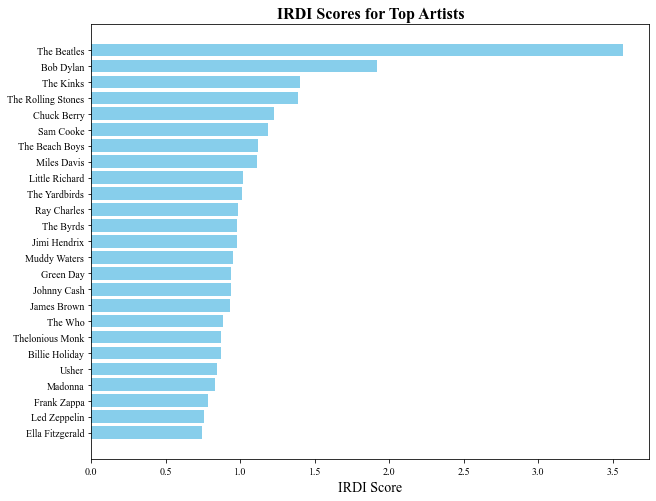

In [39]:
# Let's plot the IRDI scores for the top artists

import matplotlib.pyplot as plt

# IRDI scores data
irdi_scores_data = {
    'The Beatles': 3.5679429044807534,
    'Bob Dylan': 1.9146910239128403,
    'The Kinks': 1.4004656243723674,
    'The Rolling Stones': 1.3884176472380394,
    'Chuck Berry': 1.2247842895480952,
    'Sam Cooke': 1.1877802000441984,
    'The Beach Boys': 1.118227383956638,
    'Miles Davis': 1.1108684415155083,
    'Little Richard': 1.0158500642267245,
    'The Yardbirds': 1.011245276643157,
    'Ray Charles': 0.9837369373400302,
    'The Byrds': 0.9793274076734881,
    'Jimi Hendrix': 0.9763249125533541,
    'Muddy Waters': 0.9537629898777769,
    'Green Day': 0.9406976769413073,
    'Johnny Cash': 0.9355608794387064,
    'James Brown': 0.9281182521885093,
    'The Who': 0.8872084682719947,
    'Thelonious Monk': 0.8730165624129494,
    'Billie Holiday': 0.867532220414319,
    'Usher': 0.846450977156264,
    'Madonna': 0.8300936916975037,
    'Frank Zappa': 0.7858295228665014,
    'Led Zeppelin': 0.758797239280729,
    'Ella Fitzgerald': 0.74207952601852
}

# Sort the data by IRDI scores
sorted_data = sorted(irdi_scores_data.items(), key=lambda x: x[1], reverse=True)

# Unzip the data
artists, irdi_scores = zip(*sorted_data)

# Set the global font to be Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Create the bar plot
plt.figure(figsize=(10, 8))
plt.barh(artists, irdi_scores, color='skyblue')
plt.xlabel('IRDI Score', fontsize=14)
plt.title('IRDI Scores for Top Artists', fontsize=16, weight='bold')
plt.gca().invert_yaxis()  # Invert y-axis to have highest score at top
plt.show()



In [52]:
def top_rank_followers(influencer_id, rank, G):
    # Initial count of followers
    count_followers = 0
    # Get all the followers of the influencer
    followers = list(G.successors(influencer_id))
    # Store followers for which the influencer is in the top 'rank'
    top_rank_followers_list = []
    # Iterate over all the followers
    for follower in followers:
        # Get all the influencers of the follower and their normed differences
        influencers = list(G.predecessors(follower))
        # Define the attributes to consider for the normed difference
        attrs = ['energy', 'acousticness', 'danceability', 'tempo', 'loudness',
                     'acousticness', 'instrumentalness', 'liveness', 'speechiness']
        # Compute the normed difference for each influencer
        normed_diffs = [(influencer, 
                         np.linalg.norm([G.nodes[influencer][attr] - G.nodes[follower][attr] for attr in attrs])) 
                        for influencer in influencers]
        # Sort the influencers by the normed difference
        sorted_influencers = sorted(normed_diffs, key=lambda x: x[1])
        # Check if the influencer is in the top 'rank' influencers for this follower
        top_rank_influencers = [influencer for influencer, normed_diff in sorted_influencers[:rank]]
        if influencer_id in top_rank_influencers:
            count_followers += 1
            top_rank_followers_list.append((G.nodes[follower]['artist_name'], [G.nodes[i]['artist_name'] for i in top_rank_influencers]))
    return count_followers, top_rank_followers_list

# Example usage
influencer_id = 754032  # Artist ID 
rank = 1  # top 3 rank
num_followers, top_rank_followers_info = top_rank_followers(influencer_id, rank, G)
print(f'The influencer {G.nodes[influencer_id]["artist_name"]} (ID {influencer_id}) is among the top {rank} influencers for {num_followers} followers.')

for follower, top_influencers in top_rank_followers_info:
    print(f'For follower {follower}, the top {rank} influencers are: {top_influencers}')

The influencer The Beatles (ID 754032) is among the top 1 influencers for 65 followers.
For follower Sparks, the top 1 influencers are: ['The Beatles']
For follower Barry Manilow, the top 1 influencers are: ['The Beatles']
For follower The Archies, the top 1 influencers are: ['The Beatles']
For follower The Lovin' Spoonful, the top 1 influencers are: ['The Beatles']
For follower Blue Rodeo, the top 1 influencers are: ['The Beatles']
For follower The Hooters, the top 1 influencers are: ['The Beatles']
For follower Keith Green, the top 1 influencers are: ['The Beatles']
For follower Boston, the top 1 influencers are: ['The Beatles']
For follower Klaatu, the top 1 influencers are: ['The Beatles']
For follower The Knickerbockers, the top 1 influencers are: ['The Beatles']
For follower It's a Beautiful Day, the top 1 influencers are: ['The Beatles']
For follower Chicago, the top 1 influencers are: ['The Beatles']
For follower Jackson Browne, the top 1 influencers are: ['The Beatles']
For fo

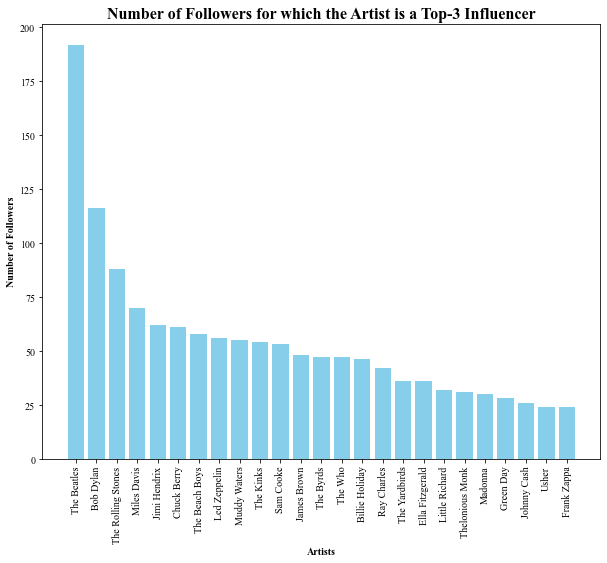

In [61]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Updating the font parameter
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']

# List of influencer names
influencer_names = [
    'The Beatles',
    'Bob Dylan',
    'The Kinks',
    'The Rolling Stones',
    'Chuck Berry',
    'Sam Cooke',
    'The Beach Boys',
    'Miles Davis',
    'Little Richard',
    'The Yardbirds',
    'Ray Charles',
    'The Byrds',
    'Jimi Hendrix',
    'Muddy Waters',
    'Green Day',
    'Johnny Cash',
    'James Brown',
    'The Who',
    'Thelonious Monk',
    'Billie Holiday',
    'Usher',
    'Madonna',
    'Frank Zappa',
    'Led Zeppelin',
    'Ella Fitzgerald'
]

# Define the rank you are interested in
rank = 3

# Calculate the number of followers for which each influencer is a top 'rank' influencer
follower_counts = {}
for influencer_name in influencer_names:
    # Find the influencer ID by searching the nodes of the graph
    influencer_id = None
    for node_id, attrs in G.nodes(data=True):
        if attrs['artist_name'] == influencer_name:
            influencer_id = node_id
            break
    if influencer_id is not None:
        num_followers, _ = top_rank_followers(influencer_id, rank, G)
        follower_counts[influencer_name] = num_followers

# Sort the data by follower counts
sorted_data = sorted(follower_counts.items(), key=lambda x: x[1], reverse=True)

# Unzip the data
influencers, follower_counts = zip(*sorted_data)

# Create the bar plot
plt.figure(figsize=(10, 8))
plt.bar(influencers, follower_counts, color='skyblue')
plt.ylabel('Number of Followers', weight='bold')
plt.xlabel('Artists', weight = 'bold')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title(f'Number of Followers for which the Artist is a Top-{rank} Influencer',fontsize=16, weight='bold')
plt.show()


### Incorporating Genres

In [56]:
import numpy as np

# List of the musical characteristics you are considering
characteristics = ['energy', 'acousticness', 'danceability', 'tempo', 'loudness',
                     'acousticness', 'instrumentalness', 'liveness', 'speechiness']

# Initialize weights for in-genre and out-genre influence
in_genre_weight = 0.43
out_genre_weight = 0.57

# Initialize a dictionary to store the influence scores for each influencer
influencer_scores = {node: 0 for node in G.nodes}

for follower in G.nodes:
    # Get the genre of the follower
    follower_genre = G.nodes[follower]['genre']
    
    # Get all the influencers of the follower
    influencers = list(G.predecessors(follower))
    
    # Calculate the normed difference for each influencer
    normed_diffs = []
    for influencer in influencers:
        # Get the genre of the influencer
        influencer_genre = G.nodes[influencer]['genre']
        
        # Get the musical characteristics for the influencer and follower
        influencer_char = np.array([G.nodes[influencer][char] for char in characteristics])
        follower_char = np.array([G.nodes[follower][char] for char in characteristics])
        
        # Calculate the normed difference
        normed_diff = np.linalg.norm(influencer_char - follower_char)
        
        normed_diffs.append((influencer, normed_diff, influencer_genre))

    # Sort the influencers by the normed difference
    sorted_influencers = sorted(normed_diffs, key=lambda x: x[1])

    # Consider the top 3 influencers
    top_n_influencers = sorted_influencers[:10]

    # Assign scores to the top-ranked influencers
    for rank, (influencer, normed_diff, influencer_genre) in enumerate(top_n_influencers, 1):
        # Determine the weight based on in-genre or out-genre influence
        weight = in_genre_weight if influencer_genre == follower_genre else out_genre_weight
        
        # Use the inverse exponential function as the score and incorporate the weight
        score = weight / np.exp(rank + normed_diff)
        
        # Add to the influencer's overall score
        influencer_scores[influencer] += score

# Print the influencers and their dominance scores
for influencer, score in sorted(influencer_scores.items(), key=lambda item: item[1], reverse=True):
    print(f"Influencer: {G.nodes[influencer]['artist_name']},  Score: {score}")


Influencer: The Beatles,  Score: 1.5609404329665302
Influencer: Bob Dylan,  Score: 0.8635794955200746
Influencer: The Rolling Stones,  Score: 0.6052087106352313
Influencer: The Kinks,  Score: 0.6042725549254799
Influencer: Ray Charles,  Score: 0.5545485110408999
Influencer: Muddy Waters,  Score: 0.5363335715831846
Influencer: Chuck Berry,  Score: 0.530197453576995
Influencer: Sam Cooke,  Score: 0.5277663923332565
Influencer: Miles Davis,  Score: 0.5194404005407306
Influencer: The Beach Boys,  Score: 0.4853993178484165
Influencer: Little Richard,  Score: 0.468779196725507
Influencer: James Brown,  Score: 0.4445998326001646
Influencer: Jimi Hendrix,  Score: 0.4415768994342639
Influencer: The Yardbirds,  Score: 0.4368141195107717
Influencer: Usher,  Score: 0.43179203351152956
Influencer: Johnny Cash,  Score: 0.42704527950838245
Influencer: The Byrds,  Score: 0.42575057392219817
Influencer: Billie Holiday,  Score: 0.4234898146578139
Influencer: Thelonious Monk,  Score: 0.41946460126521906


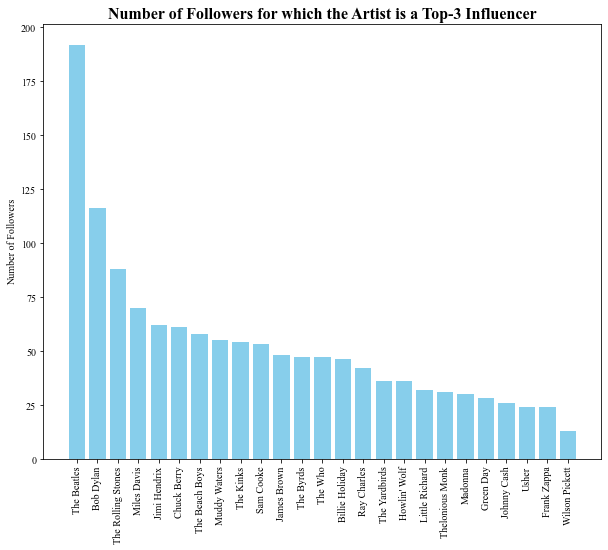

In [59]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Updating the font parameter
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']

# List of influencer names
influencer_names = [
'The Beatles',
'Bob Dylan',
'The Rolling Stones',
'The Kinks',
'Ray Charles',
'Muddy Waters',
'Chuck Berry',
'Sam Cooke',
'Miles Davis',
'The Beach Boys',
'Little Richard',
'James Brown',
'Jimi Hendrix',
'The Yardbirds',
'Usher',
'Johnny Cash',
'The Byrds',
'Billie Holiday',
'Thelonious Monk',
'Madonna',
'Green Day',
'The Who',
'Wilson Pickett',
"Howlin' Wolf",
'Frank Zappa'
]

# Define the rank you are interested in
rank = 3

# Calculate the number of followers for which each influencer is a top 'rank' influencer
follower_counts = {}
for influencer_name in influencer_names:
    # Find the influencer ID by searching the nodes of the graph
    influencer_id = None
    for node_id, attrs in G.nodes(data=True):
        if attrs['artist_name'] == influencer_name:
            influencer_id = node_id
            break
    if influencer_id is not None:
        num_followers, _ = top_rank_followers(influencer_id, rank, G)
        follower_counts[influencer_name] = num_followers

# Sort the data by follower counts
sorted_data = sorted(follower_counts.items(), key=lambda x: x[1], reverse=True)

# Unzip the data
influencers, follower_counts = zip(*sorted_data)

# Create the bar plot
plt.figure(figsize=(10, 8))
plt.bar(influencers, follower_counts, color='skyblue')
plt.ylabel('Number of Followers')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title(f'Number of Followers for which the Artist is a Top-{rank} Influencer',fontsize=16, weight='bold')
plt.show()